In [1]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict, Optional
from langchain_core.documents import Document
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langgraph.graph.message import add_messages
from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

import json
import requests
import base64
import logging
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model = ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=GROQ_API_KEY
)

In [3]:
res = model.invoke("Hello, world!")


In [4]:
res.content

"Hello, world. It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [ ]:

#langgraph state
class AgentState(TypedDict):
    human_input: str
    intent: dict
    
# Intent Classifier Node
def intent_classifier(state: AgentState) -> AgentState:
    INTENT_SCHEMA = {
        "intent": str,
        "appointment_date": Optional[str],
        "doctor_name": Optional[str]}
    
    user_message = state["human_input"]

    # Prompt for intent classification
    prompt = f"""You are an AI assistant that classifies user intents and extracts appointment information.

Analyze the user message and:
1. Classify the intent (possible intents: "book_appointment", "cancel_appointment", "reschedule_appointment", "other")
2. Extract relevant information if the intent is appointment-related

User Message: "{user_message}"

Return ONLY a valid JSON object with the following structure (no additional text or markdown):
{{
    "intent": "the classified intent",
    "appointment_date": "extracted date in YYYY-MM-DD format or null",
    "appointment_time": "extracted time in HH:MM format or null",
    "doctor_name": "extracted doctor name or null",
    "confidence": confidence score between 0 and 1
}}

Rules:
- Set fields to null if information is not mentioned
- For dates, convert relative dates (tomorrow, next Monday) to specific dates
- Today's date is {get_today_date()}
- Be precise with confidence scores

User Input: {user_message}
"""   
# Parse into json
    response = model.invoke(prompt)
    try:
        state["intent"] = json.loads(response.content)
    except json.JSONDecodeError:
        logging.error("Failed to parse JSON from model response")
        state["intent"] = {"intent": "other", "appointment_date": None, "doctor_name": None}
    return state


def get_today_date() -> str:
    """Helper function to get today's date in YYYY-MM-DD format."""
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")


def build_agent_graph() -> StateGraph[AgentState]:
    graph = StateGraph(AgentState)
    graph.add_node("intent_classifier", intent_classifier)

    graph.add_edge(START, "intent_classifier")
    graph.add_edge("intent_classifier", END)
    
    return graph.compile()



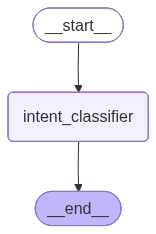

In [6]:
app = build_agent_graph()
app

In [ ]:
if __name__ == "__main__":

    initial_state: AgentState = {
        "human_input": "I would like to check availablity of an appointment with Dr. Smith next Monday at 10 AM.",
        "intent": {},
    }
    final_state = app.invoke(initial_state)
    print("Final State:", final_state)

Final State: {'human_input': 'I would like to check availablity of an appointment with Dr. Smith next Monday at 10 AM.', 'intent': {'intent': 'book_appointment', 'appointment_date': '2026-01-25', 'appointment_time': '10:00', 'doctor_name': 'Dr. Smith', 'confidence': 0.95}}


In [11]:
final_state['intent']

{'intent': 'book_appointment',
 'appointment_date': '2026-01-25',
 'appointment_time': '10:00',
 'doctor_name': 'Dr. Smith',
 'confidence': 0.95}

In [12]:
initial_state: AgentState = {
    "human_input": "I would like to book an appointment with Dr. Smith next Monday at 10 AM.",
    "intent": {},
}

res = intent_classifier(initial_state)
res


{'human_input': 'I would like to book an appointment with Dr. Smith next Monday at 10 AM.',
 'intent': {'intent': 'book_appointment',
  'appointment_date': '2024-01-22',
  'appointment_time': '10:00',
  'doctor_name': 'Dr. Smith',
  'confidence': 1}}

In [25]:
from pydantic import BaseModel, Field
from typing import Literal
from datetime import datetime

class IntentSchema(BaseModel):
    """Extract intent and entities for the medical booking system."""
    intent: Literal["book_appointment", "check_availability", "other"]
    doctor_name: Optional[str] = Field(None, description="Name of the doctor")
    appointment_date: Optional[str] = Field(None, description="Date (YYYY-MM-DD)")
    
def extraction_node(state: AgentState):
    # This node turns "Book Dr. Ahuja tomorrow morning" into structured JSON
    llm = model.with_structured_output(IntentSchema)
    context = f"Today's date is {get_today_date()}. user input: {state['human_input']}"
    result = llm.invoke(context)

    return {"extracted_data": result}

extraction_node(initial_state)

{'extracted_data': IntentSchema(intent='check_availability', doctor_name='Dr. Smith', appointment_date='2026-01-25')}

In [22]:
initial_state: AgentState = {
    "human_input": "I would like to check availablity with Dr. Smith next Monday at 10 AM.",
    "intent": {},
}
extraction_node(initial_state)

{'extracted_data': IntentSchema(intent='check_availability', doctor_name='Dr. Smith', appointment_date=datetime.datetime(2024, 1, 22, 10, 0))}